In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [6]:
# reading input data
with open("../data/tinyshakespeare.txt", "r", encoding="utf-8") as file:
    data = file.read()

In [7]:
print(f"Length of dataset w.r.t chars: {len(data)}\n")
print(data[:1000])

Length of dataset w.r.t chars: 1115394

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger

In [8]:
# all unique chars
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("".join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [9]:
# tokenization (mapping for char to int)
ch_to_id = {ch:i for i, ch in enumerate(chars)}
id_to_ch = {i:ch for i, ch in enumerate(chars)}
def encode(s):
    return [ch_to_id[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([id_to_ch[i] for i in l]) # decoder: take a list of integers, output a string

# tests
print(encode("Hello world!"))
print(decode(encode("Hello World!")))

[20, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42, 2]
Hello World!


In [10]:
# tokenizing enitire dataset and converting them into tensors
data = torch.tensor(encode(data), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # 1st 1000 char tensors

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [11]:
# train, val split
thresh = int(0.9 * len(data))
train_data = data[:thresh] # 90%
val_data = data[thresh:] # 10%

In [35]:
# dataloader: outs batches of x and y pairs
batch_size = 4 # n sequence to process parallaly
block_size = 8 # context length
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_batches(split):
    """
    generate batched in and out pairs
    """
    data = train_data if split == "train" else val_data
    idx = torch.randint(len(data) - block_size, (batch_size, ))
    x = torch.stack([data[i:i + block_size] for i in idx])
    y = torch.stack([data[i + 1: i + block_size + 1] for i in idx])
    x, y = x.to(device), y.to(device)
    return x, y

mini_x, mini_y = get_batches("train") # batch
print(f"Inputs shape: {mini_x.shape}\nInputs: {mini_x}\n")
print(f"Target shape: {mini_y.shape}\nTarget: {mini_y}\n")
print("--------------------------------------------------\n")

# insights into the batched data
for b in range(batch_size):
    for t in range(block_size):
        context = mini_x[b, :t+1]
        target = mini_y[b, t]
        print(f"Input: {context.tolist()}, Target: {target}")

Inputs shape: torch.Size([4, 8])
Inputs: tensor([[ 6,  1, 63, 53, 59,  1, 46, 39],
        [ 1, 49, 52, 53, 41, 49,  1, 51],
        [13, 32, 17, 30, 10,  0, 26, 53],
        [ 1,  5, 46, 39, 60, 47, 53, 56]], device='cuda:0')

Target shape: torch.Size([4, 8])
Target: tensor([[ 1, 63, 53, 59,  1, 46, 39, 60],
        [49, 52, 53, 41, 49,  1, 51, 43],
        [32, 17, 30, 10,  0, 26, 53, 61],
        [ 5, 46, 39, 60, 47, 53, 56,  1]], device='cuda:0')

--------------------------------------------------

Input: [6], Target: 1
Input: [6, 1], Target: 63
Input: [6, 1, 63], Target: 53
Input: [6, 1, 63, 53], Target: 59
Input: [6, 1, 63, 53, 59], Target: 1
Input: [6, 1, 63, 53, 59, 1], Target: 46
Input: [6, 1, 63, 53, 59, 1, 46], Target: 39
Input: [6, 1, 63, 53, 59, 1, 46, 39], Target: 60
Input: [1], Target: 49
Input: [1, 49], Target: 52
Input: [1, 49, 52], Target: 53
Input: [1, 49, 52, 53], Target: 41
Input: [1, 49, 52, 53, 41], Target: 49
Input: [1, 49, 52, 53, 41, 49], Target: 1
Input: [1, 

In [13]:
# bigram class
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers batch, time/context
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

    def sample(self, idx, max_new_tokens):
        return decode(self.generate(idx, max_new_tokens)[0].tolist())

bigram_model = BigramLanguageModel(vocab_size)
logits, loss = bigram_model(mini_x, mini_y)
print(f"Loss: {loss}")

Loss: 4.741575717926025


In [14]:
# prediction before training
print(bigram_model.sample(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100))


 jugHvwkrQ-iL;yy3HtbL: HRqfLKK?Lwo.F
qyo
:XTKD:Qqz3ouRhwoijMczNO!KEbSK!B;?buNqCd.jJgA;fsiRLQYpxuJZIS


In [15]:
# # predictions before training
# print(decode(bigram_model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

In [16]:
# optimizer
optimizer = torch.optim.AdamW(bigram_model.parameters(), lr=1e-3)

In [17]:
# Training bigram model
batch_size = 32
epochs = 10000

for epoch in range(epochs):
    # getting batches
    xb, yb = get_batches("train")

    # loss
    logits, loss = bigram_model(xb, yb)

    # setting grad to zero
    optimizer.zero_grad(set_to_none=True)

    # backprop
    loss.backward()

    # update params
    optimizer.step()
    if (epoch+1) % 1000 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1000, Loss: 3.634788751602173
Epoch: 2000, Loss: 3.0597639083862305
Epoch: 3000, Loss: 2.8163256645202637
Epoch: 4000, Loss: 2.6066744327545166
Epoch: 5000, Loss: 2.473252773284912
Epoch: 6000, Loss: 2.650883674621582
Epoch: 7000, Loss: 2.373549222946167
Epoch: 8000, Loss: 2.5298757553100586
Epoch: 9000, Loss: 2.450838565826416
Epoch: 10000, Loss: 2.5072290897369385


In [18]:
# prediction after training
print(bigram_model.sample(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500))


Thefryo aiou chietherd.
Foug mamunty d gostr?
Al d?
Gimy Witotha
Th avito'shofr,-mbe ser mpe th de hin f s foood
wot;'steloroitnt IEN:

MERCETZAne merll hik-QUEShit, th?F pofer sund haththet, atheord rpin:
K:

POKI micome ssovy,
Whis ssthe te HARI3&chikef h ishes adermengrnMEDant-GLE:
NGLThe lle yome r lllinos h s athean CA:
IFine, a'tours'd d bathe here? cht d,

Beth,
D:
ORoud t mbe t,
H:
Herciseer:

SengXbe st astw by harfteche thest ORERIfr  p or ngg ha ie,

INRA:
KINGLEO: usovinopithe belsch


In [19]:
# # predictions after training
# print(decode(bigram_model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

In [20]:
# intuition for masked self-attention
B, T, C = 4, 8, 2 # Batch, Time(context length), Channels(embeddings or info at B,T)
x = torch.randn(B, T, C)
print(f"x Shape: {x.shape}")

# we want ith token to have attention to all tokens from i-T to i
# hence x[b, t] = mean of i<t x[b, i]
xbow = torch.zeros((B, T, C)) # averaging
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # (t, C)
        xbow[b, t] = torch.mean(xprev, 0)
x[0], xbow[0]

x Shape: torch.Size([4, 8, 2])


(tensor([[ 0.1334,  1.4106],
         [-0.6840,  1.5873],
         [-1.7562,  1.6373],
         [-1.2012, -0.7698],
         [-1.8494,  1.0272],
         [ 0.6156, -1.9928],
         [-0.4688,  0.1666],
         [ 0.1309, -1.6012]]),
 tensor([[ 0.1334,  1.4106],
         [-0.2753,  1.4989],
         [-0.7689,  1.5451],
         [-0.8770,  0.9663],
         [-1.0715,  0.9785],
         [-0.7903,  0.4833],
         [-0.7444,  0.4381],
         [-0.6350,  0.1832]]))

In [21]:
# masked self-attention using matrix multiplication
weights = torch.tril(torch.ones(T, T)) # lower triangular matrix
weights = weights / weights.sum(1, keepdim=True) # row normalization
print("Weights for self-attention: \n", weights)
xbow2 =  weights @ x # (B, T, T) @ (B, T, C) = (B, T, C), here the weights are averaging the context so that the ith token has attention to all tokens from i-T to i
torch.allclose(xbow, xbow2) # tells if the two tensors are equal

Weights for self-attention: 
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


True

In [22]:
# masked self-attention using softmax
tril = torch.tril(torch.ones(T, T)) # lower triangular matrix
weights = torch.zeros((T, T))
weights = weights.masked_fill(tril == 0, float('-inf')) # masking the upper triangular part
print(f"Weights before softmax: \n{weights}\n")
weights = F.softmax(weights, dim=1) # row normalization
print(f"Weights after softmax: \n{weights}")

Weights before softmax: 
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

Weights after softmax: 
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250

In [23]:
# masked self-attention (CRUX)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# single headed masked self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
weights =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

v = value(x)
out = weights @ v

print(f"Output shape: {out.shape}")
print(f"Weight: \n{weights[0]}")

Output shape: torch.Size([4, 8, 16])
Weight: 
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2163, 0.7837, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5824, 0.0998, 0.3177, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0112, 0.8160, 0.1198, 0.0530, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0392, 0.0536, 0.1746, 0.1672, 0.5654, 0.0000, 0.0000, 0.0000],
        [0.1316, 0.1314, 0.1636, 0.3030, 0.0154, 0.2550, 0.0000, 0.0000],
        [0.1410, 0.0644, 0.0195, 0.0156, 0.4394, 0.1737, 0.1463, 0.0000],
        [0.0265, 0.0740, 0.0878, 0.1050, 0.0268, 0.0052, 0.4948, 0.1798]],
       grad_fn=<SelectBackward0>)


In [24]:
# scaled masked self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
weights =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights / (head_size ** 0.5), dim=-1) # scaling helps the softmax to be more stable and less sensitive to large values

v = value(x)
out = weights @ v

print(f"Output shape: {out.shape}")
print(f"Weight: \n{weights[0]}")

Output shape: torch.Size([4, 8, 16])
Weight: 
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5063, 0.4937, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2325, 0.4955, 0.2720, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2599, 0.1953, 0.2446, 0.3002, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1443, 0.2273, 0.1904, 0.2438, 0.1943, 0.0000, 0.0000, 0.0000],
        [0.1047, 0.2245, 0.0693, 0.3134, 0.1506, 0.1376, 0.0000, 0.0000],
        [0.1676, 0.1471, 0.1209, 0.1348, 0.1518, 0.1232, 0.1547, 0.0000],
        [0.1164, 0.1195, 0.1314, 0.1772, 0.0644, 0.2043, 0.1008, 0.0858]],
       grad_fn=<SelectBackward0>)


## GPT

In [42]:
# hyperparams
batch_size = 64
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
num_embed = 384
num_head = 6
num_layer = 6
dropout = 0.2

In [43]:
class LayerNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [44]:
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(num_embed, head_size, bias=False)
        self.query = nn.Linear(num_embed, head_size, bias=False)
        self.value = nn.Linear(num_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        weights = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        weights = F.softmax(weights, dim=-1) # (B, T, T)
        weights = self.dropout(weights)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = weights @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [45]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.projection = nn.Linear(num_heads * head_size, num_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection(out)
        out = self.dropout(out)
        return out

In [46]:
class FeedFoward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [47]:
class Block(nn.Module):

    def __init__(self, num_embd, num_head):
        super().__init__()
        head_size = num_embd // num_head
        self.self_attention = MultiHeadAttention(num_head, head_size)
        self.ffwd = FeedFoward(num_embd)
        self.ln1 = nn.LayerNorm(num_embd)
        self.ln2 = nn.LayerNorm(num_embd)

    def forward(self, x):
        x = x + self.self_attention(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [48]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, num_embed)
        self.positional_embedding_table = nn.Embedding(block_size, num_embed)
        self.blocks = nn.Sequential(*[Block(num_embed, num_head) for _ in range(num_layer)])
        self.layer_norm = nn.LayerNorm(num_embed)
        self.linear = nn.Linear(num_embed, vocab_size)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        token_embeddings = self.token_embedding_table(idx) # (B,T,C)
        position_embeddings = self.positional_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = token_embeddings + position_embeddings # (B,T,C)
        x = self.blocks(x)
        x = self.layer_norm(x)
        logits = self.linear(x) # (B,T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # take only the last block_size tokens
            idx_context = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_context)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [49]:
# model, optimizer
model = GPTLanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# print number of parameters
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

10.788929 M parameters


In [50]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batches(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [51]:
from tqdm import tqdm

train_losses = []
val_losses = []
for iter in tqdm(range(max_iters)):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        # appending the losses
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batches('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

step 0: train loss 4.3370, val loss 4.3359


 10%|█         | 501/5000 [06:00<25:30:40, 20.41s/it]

step 500: train loss 1.8942, val loss 1.9963


 20%|██        | 1001/5000 [11:00<22:36:00, 20.35s/it]

step 1000: train loss 1.5471, val loss 1.7359


 30%|███       | 1501/5000 [16:00<19:48:34, 20.38s/it]

step 1500: train loss 1.4037, val loss 1.6202


 40%|████      | 2001/5000 [20:59<16:57:34, 20.36s/it]

step 2000: train loss 1.3187, val loss 1.5687


 50%|█████     | 2501/5000 [25:57<14:06:26, 20.32s/it]

step 2500: train loss 1.2616, val loss 1.5226


 60%|██████    | 3001/5000 [30:56<11:17:39, 20.34s/it]

step 3000: train loss 1.2125, val loss 1.5085


 70%|███████   | 3501/5000 [35:55<8:28:30, 20.35s/it]

step 3500: train loss 1.1771, val loss 1.4923


 80%|████████  | 4001/5000 [40:54<5:38:45, 20.35s/it]

step 4000: train loss 1.1363, val loss 1.4957


 90%|█████████ | 4501/5000 [45:52<2:48:44, 20.29s/it]

step 4500: train loss 1.1023, val loss 1.4875


100%|██████████| 5000/5000 [50:50<00:00,  1.64it/s]

step 4999: train loss 1.0697, val loss 1.4984


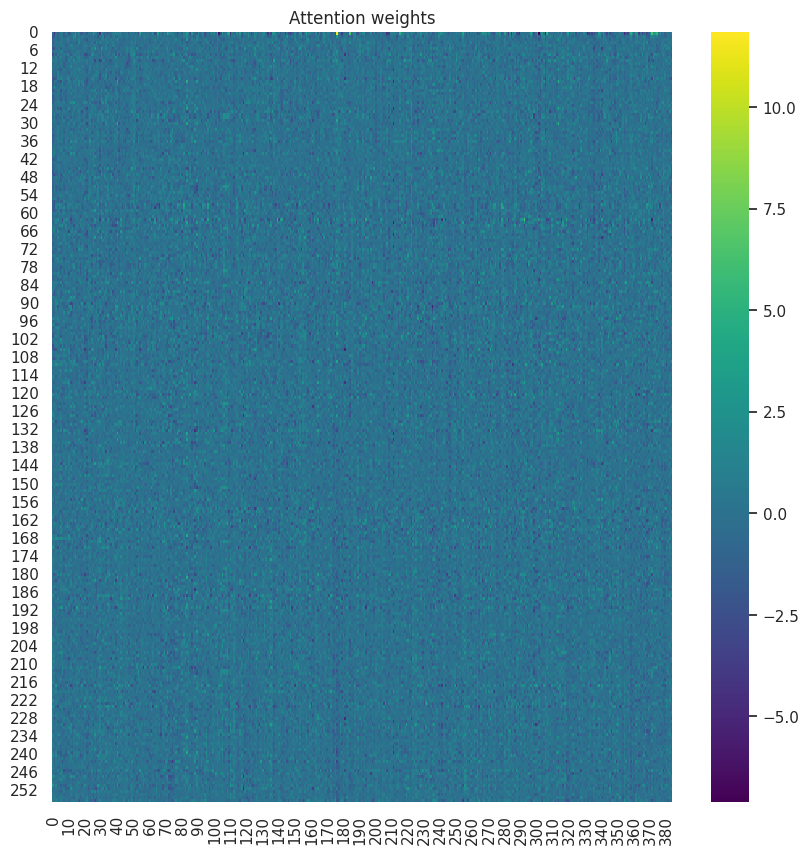

In [52]:
# plotting the attention weights
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# get the next batch
xb, yb = get_batches("val")
xb, yb = xb.to(device), yb.to(device)
# forward the model
B, T = xb.shape
token_embeddings = model.token_embedding_table(xb) # (B,T,C)
position_embeddings = model.positional_embedding_table(torch.arange(T, device=device)) # (T,C)
x = token_embeddings + position_embeddings # (B,T,C)
attention = model.blocks[0].self_attention
weights = attention(x) # (B,T,C)
weights = weights[0].cpu().detach().numpy() # (T,T)
plt.figure(figsize=(10,10))
sns.heatmap(weights, cmap='viridis')
plt.title('Attention weights')
plt.show()

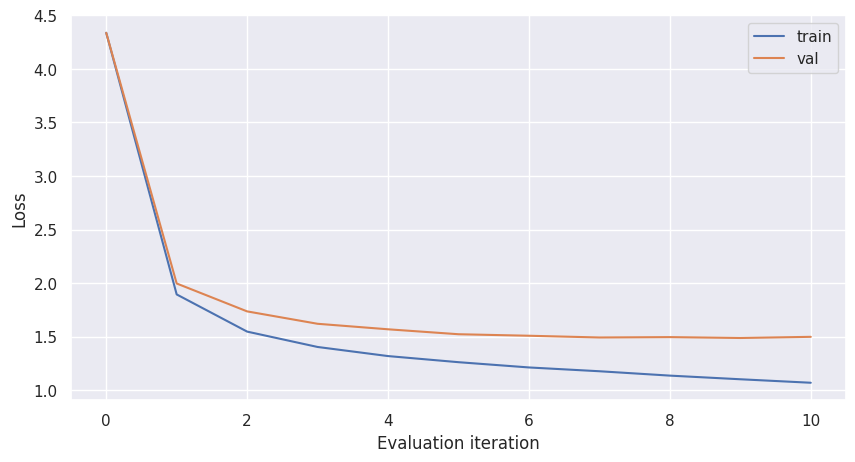

In [53]:
# plotting the losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Evaluation iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=1000)[0].tolist()))



PAULINA:
Come to your minute, noble Lord Aumerle with his treasury.
But, a man! an's at the men time I aecuty!
Sirrah, or else to-morrow; best met, thought thing
And slew 'This same one a' the lark'd of
Thy father; for I
I need, bid me henceforath falses, in
I proceed meet and so. Wherefore, sir, do not make
Thee propest: somethink me insinuation
The may may cure our selforance' fast company:
Not myself. I put husband unto my limb
splangue of my uncortaint I up.

Nurse:
Come, death, you lie not
to the young son and book in anchor; smeal at,
At letter a sense monation
Of noise and enmoration.

ProvOLIXENES:
Seize medily content with the present
Nor warm'd from me your being, that bone which'd I?

CAPULET:
Sweet Catesby; gentle Polixenes; what is much she
That sensel-ripe; be, devised, brawn the heavy
As I banish'd in simple, compething Marciana:
Softer, only your children clear God
To the office's good from our love's eye
That we have work the grace of the people;
Our love did lubstin

In [57]:
# saving the weights of the model
torch.save(model.state_dict(), '../weights/atomic-GPT.pth')

In [58]:
# loading saved model
model = GPTLanguageModel()
model.load_state_dict(torch.load('../weights/atomic-GPT.pth'))
model.eval()

GPTLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (positional_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (self_attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (projection): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05,